In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from sklearn.dummy import DummyRegressor
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor

In [2]:
df = pd.read_csv("../data/synthetic_lab_turnaround_sample_50k.csv")
df.head()

,test_type,specimen_type,priority,location,day_of_week,hour_received,shift,staff_on_shift,samples_in_queue,batch_size,is_batch_test,instrument,instrument_capacity,contamination_flag,insufficient_sample_flag,instrument_downtime_flag,turnaround_time_minutes
0,PCR_Respiratory,stool,routine,Theatre,6,11,day,7,63,21,1,PCR_Rig_2,24,0,0,0,279
1,MRSA_Screen,stool,urgent,Outpatient,5,11,day,11,51,24,1,PCR_Rig_2,24,0,0,0,140
2,Biochemistry_Panel,blood,routine,GP,6,17,evening,6,40,14,0,Analyzer_A,80,0,0,0,90
3,MRSA_Screen,sputum,urgent,ED,6,13,day,9,65,38,1,PCR_Rig_2,24,0,0,0,249
4,Wound_Swab,swab,routine,GP,4,1,night,5,30,11,0,Culture_Incubator,200,0,0,0,1416


In [3]:
df.shape, df.columns

((50000, 17),
 Index(['test_type', 'specimen_type', 'priority', 'location', 'day_of_week',
        'hour_received', 'shift', 'staff_on_shift', 'samples_in_queue',
        'batch_size', 'is_batch_test', 'instrument', 'instrument_capacity',
        'contamination_flag', 'insufficient_sample_flag',
        'instrument_downtime_flag', 'turnaround_time_minutes'],
       dtype='str'))

In [4]:
df["turnaround_time_minutes"].describe()

count    50000.000000
mean      1467.994680
std       1878.669044
min         23.000000
25%        178.000000
50%        317.000000
75%       2493.000000
max      16593.000000
Name: turnaround_time_minutes, dtype: float64

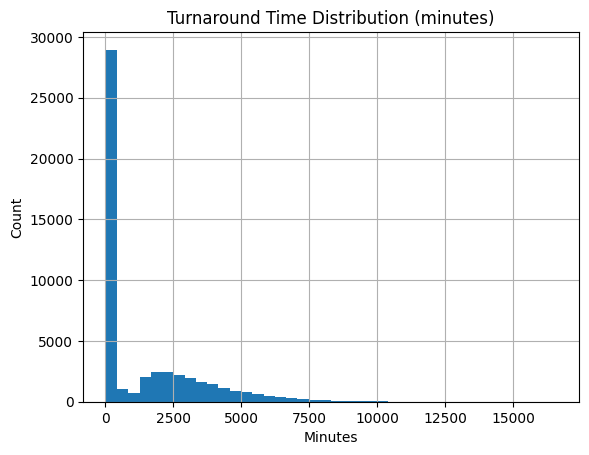

In [5]:
plt.figure()
df["turnaround_time_minutes"].hist(bins=40)
plt.title("Turnaround Time Distribution (minutes)")
plt.xlabel("Minutes")
plt.ylabel("Count")
plt.show()

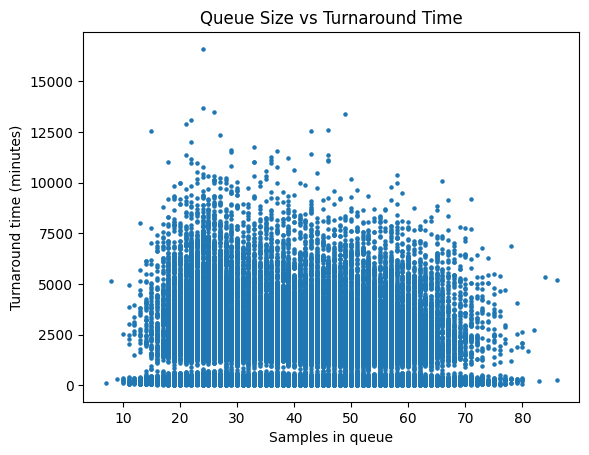

In [6]:
plt.figure()
plt.scatter(df["samples_in_queue"], df["turnaround_time_minutes"], s=5)
plt.title("Queue Size vs Turnaround Time")
plt.xlabel("Samples in queue")
plt.ylabel("Turnaround time (minutes)")
plt.show()

In [7]:
target = "turnaround_time_minutes"
X = df.drop(columns=[target])
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

X_train.shape, X_test.shape

((40000, 16), (10000, 16))

In [8]:
cat_cols = X.select_dtypes(include=["object"]).columns.tolist()
num_cols = X.select_dtypes(exclude=["object"]).columns.tolist()

cat_cols, num_cols

C:\Users\Emmanuel Ndira\AppData\Local\Temp\ipykernel_17652\2467507174.py:1: Pandas4Warning: For backward compatibility, 'str' dtypes are included by select_dtypes when 'object' dtype is specified. This behavior is deprecated and will be removed in a future version. Explicitly pass 'str' to `include` to select them, or to `exclude` to remove them and silence this warning.
See https://pandas.pydata.org/docs/user_guide/migration-3-strings.html#string-migration-select-dtypes for details on how to write code that works with pandas 2 and 3.
  cat_cols = X.select_dtypes(include=["object"]).columns.tolist()


(['test_type', 'specimen_type', 'priority', 'location', 'shift', 'instrument'],
 ['day_of_week',
  'hour_received',
  'staff_on_shift',
  'samples_in_queue',
  'batch_size',
  'is_batch_test',
  'instrument_capacity',
  'contamination_flag',
  'insufficient_sample_flag',
  'instrument_downtime_flag'])

In [9]:
preprocess = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
        ("num", "passthrough", num_cols),
    ]
)

In [12]:
def evaluate(model, X_train, X_test, y_train, y_test, name="model"):
    model.fit(X_train, y_train)
    preds = model.predict(X_test)

    mae = mean_absolute_error(y_test, preds)
    mse = mean_squared_error(y_test, preds)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, preds)

    print(f"{name}:")
    print(f"  MAE:  {mae:,.2f} minutes")
    print(f"  RMSE: {rmse:,.2f} minutes")
    print(f"  R²:   {r2:.3f}")

    return preds

In [13]:
baseline = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", DummyRegressor(strategy="median"))
])

baseline_preds = evaluate(
    baseline, X_train, X_test, y_train, y_test,
    name="Baseline (Median)"
)

Baseline (Median):
  MAE:  1,303.50 minutes
  RMSE: 2,219.89 minutes
  R²:   -0.375


In [14]:
ridge = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", Ridge(alpha=1.0, random_state=42))
])

ridge_preds = evaluate(ridge, X_train, X_test, y_train, y_test, name="Ridge Regression")

Ridge Regression:
  MAE:  389.18 minutes
  RMSE: 720.56 minutes
  R²:   0.855


In [15]:
rf = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", RandomForestRegressor(
        n_estimators=200,
        random_state=42,
        n_jobs=-1
    ))
])

rf_preds = evaluate(rf, X_train, X_test, y_train, y_test, name="Random Forest Regressor")

Random Forest Regressor:
  MAE:  336.47 minutes
  RMSE: 700.81 minutes
  R²:   0.863


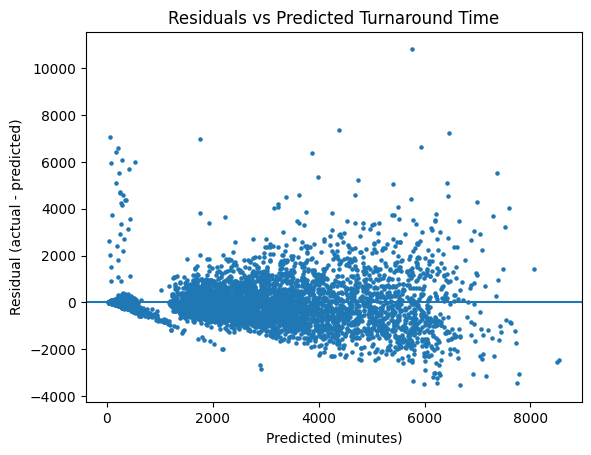

In [16]:
best_preds = rf_preds

residuals = y_test - best_preds
plt.figure()
plt.scatter(best_preds, residuals, s=5)
plt.axhline(0)
plt.title("Residuals vs Predicted Turnaround Time")
plt.xlabel("Predicted (minutes)")
plt.ylabel("Residual (actual - predicted)")
plt.show()

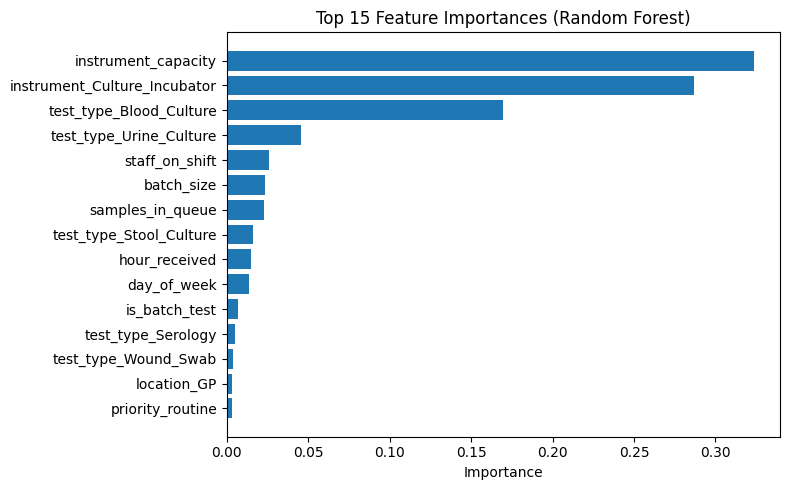

,feature,importance
39,instrument_capacity,0.323475
30,instrument_Culture_Incubator,0.287142
1,test_type_Blood_Culture,0.169304
8,test_type_Urine_Culture,0.045453
35,staff_on_shift,0.026023
37,batch_size,0.023658
36,samples_in_queue,0.022755
7,test_type_Stool_Culture,0.016140
34,hour_received,0.015081
33,day_of_week,0.013858


In [17]:
rf.fit(X_train, y_train)

ohe = rf.named_steps["preprocess"].named_transformers_["cat"]
cat_feature_names = ohe.get_feature_names_out(cat_cols)
feature_names = np.concatenate([cat_feature_names, np.array(num_cols)])

importances = rf.named_steps["model"].feature_importances_
imp_df = pd.DataFrame({"feature": feature_names, "importance": importances})
imp_df = imp_df.sort_values("importance", ascending=False).head(15)

plt.figure(figsize=(8,5))
plt.barh(imp_df["feature"][::-1], imp_df["importance"][::-1])
plt.title("Top 15 Feature Importances (Random Forest)")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

imp_df